# A Deep Reinforcement Learning Approach to Stock Portfolio Optimization
*Submitted in partial fulfillment of the requirements for B.Sc. Applied Mathematics at Mahidol University (MUIC)*

## Import Dependancies

In [1]:
import os
from tqdm.notebook import tqdm
import yfinance as yf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import risk_matrix
from pypfopt.efficient_frontier import EfficientFrontier

from portfolio_environment import PortfolioEnv
from stable_baselines3 import DQN

(CVXPY) Apr 08 10:57:43 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')


## Data Preprocessing

### Date Range and Stock Tickers

In [2]:
# 10 arbitrarily selected stocks from the Dow Jones
TICKERS = ['AXP', 'AAPL', 'BA', 'GS', 'INTC', 'JNJ', 'KO', 'NKE', 'PG', 'DIS']

# 9 years of pre COVID-19 data
TRAIN_START = '2010-01-01'
TRAIN_END = '2019-12-31'

# 1 year of heavily COVID-19 affected data and 1 year of post COVID-19 growth
VAL_START = '2020-01-01'
VAL_END = '2021-12-31'

# 1 year of recession period
TEST_START = '2022-01-01'
TEST_END = '2022-12-31'

### Risk Free Rate of Return

In [3]:
yearly_risk_free_rate_percentage = yf.download('^TNX', start = TRAIN_START, end = TEST_END, interval = '1d')['Close']
risk_free_rate = (1 + yearly_risk_free_rate_percentage / 100) ** (1 / 252) - 1 # daily risk free rate

[*********************100%***********************]  1 of 1 completed


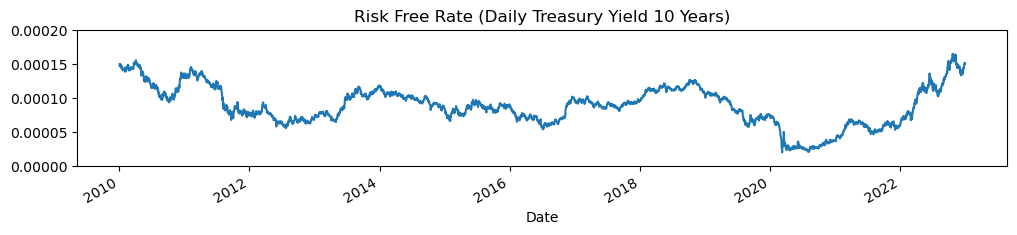

In [4]:
risk_free_rate.plot(title='Risk Free Rate (Daily Treasury Yield 10 Years)', figsize=(12,2), legend=False, ylim=(0,2e-4));

### Stock Returns

In [5]:
data = {}
for ticker in tqdm(TICKERS):
    data[ticker] = yf.download(
        ticker,
        start = TRAIN_START,
        end = TEST_END,
        interval = '1d',
        progress = False
    )

  0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
df = pd.DataFrame(index=pd.date_range(start=TRAIN_START, end=TEST_END, freq='d')) # create a dataframe with a full index

df['RISK_FREE'] = risk_free_rate
for ticker in TICKERS:
    df[ticker] = data[ticker]['Adj Close'].pct_change(1) # fill in each return column
    df[f'{ticker}_VOLUME'] = data[ticker]['Volume'].pct_change(1)

print(f'Number of all NaN rows dropped: {df.isna().all(axis=1).sum()}')
df.dropna(axis=0, how='all', inplace=True) # drop rows with all NaN e.g first row, weekends, public holidays

Number of all NaN rows dropped: 1476


In [7]:
# Fill remaining `NaN values`
print(df.isna().sum())
df.fillna(value=0, inplace=True) # replace any remaining NaN values with 0 return (no change in stock price)

RISK_FREE      3
AXP            1
AXP_VOLUME     1
AAPL           1
AAPL_VOLUME    1
BA             1
BA_VOLUME      1
GS             1
GS_VOLUME      1
INTC           1
INTC_VOLUME    1
JNJ            1
JNJ_VOLUME     1
KO             1
KO_VOLUME      1
NKE            1
NKE_VOLUME     1
PG             1
PG_VOLUME      1
DIS            1
DIS_VOLUME     1
dtype: int64


### Visualization of Returns and Volume

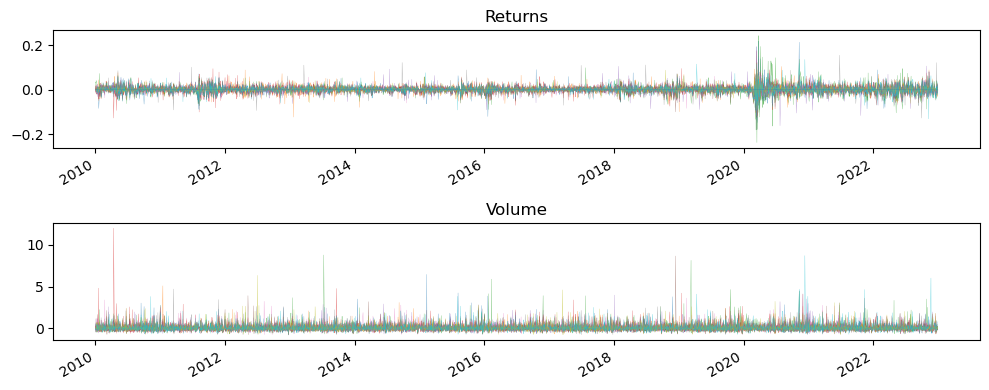

In [8]:
fig, axes = plt.subplots(2)
df[[ticker for ticker in TICKERS] + ['RISK_FREE']].plot(title='Returns', figsize=(10, 4), legend=False, lw=0.2, alpha=0.8, ax=axes[0]);
df[[f'{ticker}_VOLUME' for ticker in TICKERS]].plot(title='Volume', legend=False, lw=0.2, alpha=0.8, ax=axes[1]);
plt.tight_layout()

### Generate Stationary Features

In [9]:
def rolling_returns(returns, window=10):
    return (returns+1).rolling(window=window).agg(lambda x : x.prod()) ** (1/window) - 1

def rolling_std(returns, window=10):
    return returns.rolling(window=window).std()

In [10]:
for ticker in tqdm(TICKERS):
    df[f'{ticker}_RETURNS_12'] = rolling_returns(df[ticker], 10)
    df[f'{ticker}_RETURNS_26'] = rolling_returns(df[ticker], 26)
    df[f'{ticker}_RETURNS_60'] = rolling_returns(df[ticker], 60)
    df[f'{ticker}_STD_20'] = rolling_std(df[ticker], 20)

  0%|          | 0/10 [00:00<?, ?it/s]

In [11]:
df = df.dropna() # drop rows with `NaN` values generated at starting periods of rolling features

### Visualization of Stationary Features

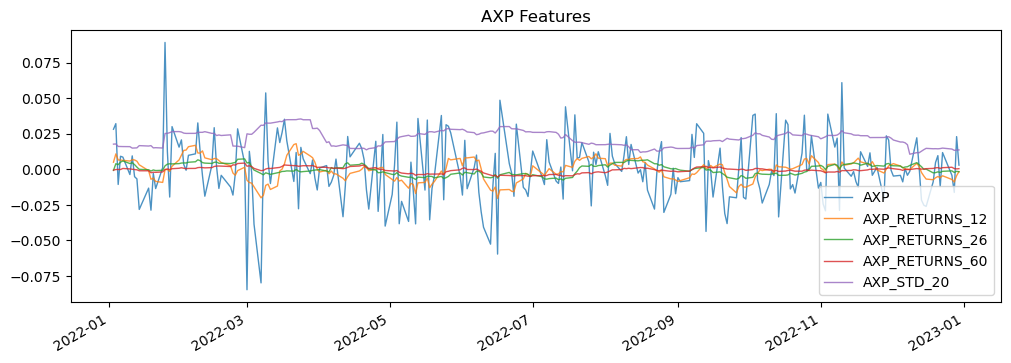

In [12]:
ticker = 'AXP'
features = [ticker, f'{ticker}_RETURNS_12', f'{ticker}_RETURNS_26', f'{ticker}_RETURNS_60', f'{ticker}_STD_20']
df.loc['2022'][features].plot(title=f'{ticker} Features', legend=True, lw=1, alpha=0.8, figsize=(12, 4));

### Train-Val-Test Split

In [13]:
train_df = df[TRAIN_START : TRAIN_END]
val_df = df[VAL_START : VAL_END]
test_df = df[TEST_START : TEST_END]

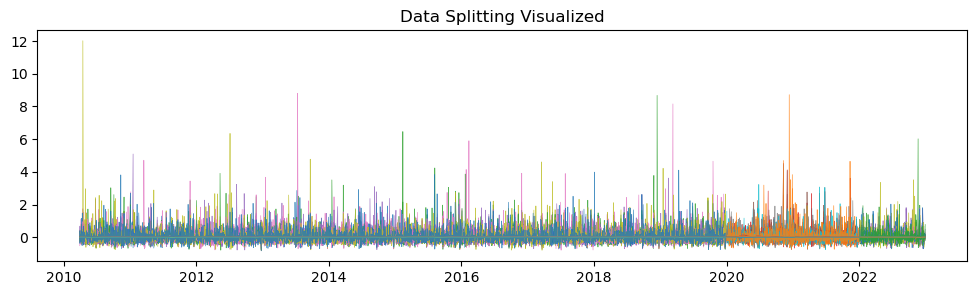

In [14]:
plt.figure(figsize=(12,3));
plt.title('Data Splitting Visualized')
plt.plot(train_df, alpha=0.8, lw=0.5);
plt.plot(val_df, alpha=0.8, lw=0.5);
plt.plot(test_df, alpha=0.8, lw=0.5);

In [15]:
data_dir = 'data'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

df.to_csv(f'{data_dir}/all_data.csv')
train_df.to_csv(f'{data_dir}/train_data.csv')
val_df.to_csv(f'{data_dir}/val_data.csv')
test_df.to_csv(f'{data_dir}/test_data.csv')

## Baselines

### DJIA Baseline

In [16]:
djia_returns = yf.download('^DJI', start = df.index[0], end = df.index[-1], interval = '1d')['Adj Close'].pct_change(1)

[*********************100%***********************]  1 of 1 completed


### Maximum Sharpe Ratio Baseline

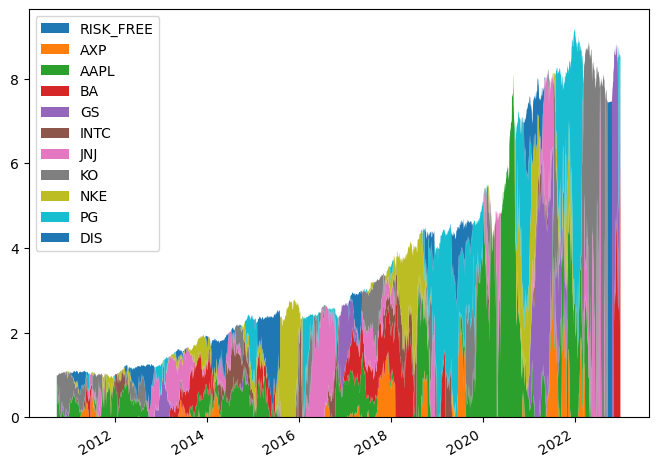

In [17]:
TICKERS = ['AXP', 'AAPL', 'BA', 'GS', 'INTC', 'JNJ', 'KO', 'NKE', 'PG', 'DIS']
RETURN_COLS = ['RISK_FREE'] + TICKERS
FEATURE_COLS = TICKERS

WINDOW_SIZE = 126 # half a trading year

env = PortfolioEnv(df, RETURN_COLS, FEATURE_COLS, episode_length=-1, window_size=WINDOW_SIZE)

obs, done = env.reset(), False
while not done:
    
    observation_df = pd.DataFrame(obs.reshape(-1, env.NUM_ASSETS), columns=FEATURE_COLS)
    annualized_mean_return = mean_historical_return(observation_df, returns_data=True, compounding=False)
    annualized_covariance = risk_matrix(observation_df, returns_data=True, method='sample_cov')
    ef = EfficientFrontier(annualized_mean_return, annualized_covariance)
    
    try:
        weights = ef.max_sharpe(risk_free_rate=(1+env.RETURNS[env.current_index,0])**252-1)
        cleaned_weights = ef.clean_weights()
        env.current_allocations = np.insert(np.array([w for w in cleaned_weights.values()]), 0, 0)
    
    except ValueError: # for when none of the assets must have an expected return exceeding the risk-free rate
        env.current_allocations = np.insert(np.zeros(len(FEATURE_COLS)), 0, 1) # invest everything into the risk free rate
    
    obs, reward, done, info = env.step(env.NUM_ASSETS) # do nothing

env.render() # title='Maximum Sharpe Ratio Portfolio Allocations'
plt.legend(loc='upper left');

max_sharpe_returns = env.get_portfolio_returns()

env.close()

### Visualizing Baselines

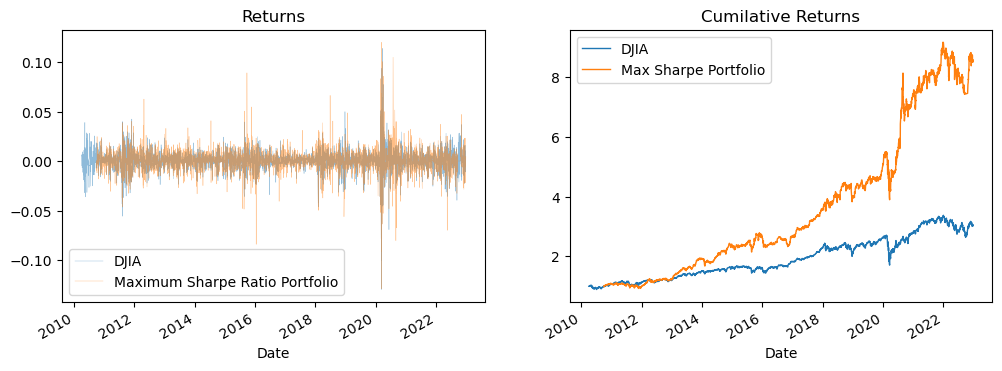

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

djia_returns.plot(ax = axes[0], lw=0.3, alpha=0.5, title='Returns', label='DJIA', legend=True);
max_sharpe_returns.plot(ax = axes[0], lw=0.3, alpha=0.5, title='Returns', label='Maximum Sharpe Ratio Portfolio', legend=True);

(djia_returns+1).cumprod().plot(ax = axes[1], lw=1, alpha=1, title='Cumilative Returns', label='DJIA', legend=True);
(max_sharpe_returns+1).cumprod().plot(ax = axes[1], lw=1, alpha=1, title='Cumilative Returns', label='Max Sharpe Portfolio', legend=True);

## Train DQN Model

In [19]:
models_dir, log_dir = 'models', 'logs'

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(log_dir):
    os.makedirs(log_dir)

In [20]:
TICKERS = ['AXP', 'AAPL', 'BA', 'GS', 'INTC', 'JNJ', 'KO', 'NKE', 'PG', 'DIS']
FEATURES = ['RETURNS_12', 'RETURNS_26', 'RETURNS_60', 'STD_20', 'VOLUME']

RETURN_COLS = ['RISK_FREE'] + [ticker for ticker in TICKERS]
FEATURE_COLS = RETURN_COLS + [f'{ticker}_{feature}' for ticker in TICKERS for feature in FEATURES]

train_env = PortfolioEnv(
    train_df,
    RETURN_COLS,
    FEATURE_COLS,
    window_size=10,
    episode_length=180,
    allocations_in_obs=True,
)

In [21]:
# # Commented out because model has already been trained
# model = DQN(
#     policy='MlpPolicy',
#     env=train_env,
#     verbose=1,
#     tensorboard_log=log_dir,
#     learning_rate=3e-4,
#     batch_size=64,
#     buffer_size=100_000,
#     exploration_fraction=1.05,
#     seed=5,
# )

In [22]:
# # Commented out because model has already been trained
# TIMESTEPS = 10_000 # number of timesteps between saves
# for i in tqdm(range(1, 300)):
#     model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name='DQN-Model')
#     model.save(f'{models_dir}/{TIMESTEPS*i}')

## Results

In [23]:
def returns_to_stats(returns):
    """
    Returns the annualized mean rate of return, annualized risk, and Sharpe ratio given an array of daily returns.
    """
    annualized_mean_rate_of_return = (1 + returns).prod() ** (252 / len(returns)) - 1
    annualized_risk = (returns.var() * 252) ** 0.5
    sharpe_ratio =  annualized_mean_rate_of_return / annualized_risk
    return {
        'rate of return' : annualized_mean_rate_of_return,
        'risk' : annualized_risk,
        'sharpe' : sharpe_ratio
    }

In [24]:
def linear_color_map(x, start_color=[1,0,0], end_color=[0,0,1]):
    """
    Maps a number x (between 0 and 1) to a color between `start_color` and `end_color`.
    """
    return [x*c1 + (1-x)*c2 for c1, c2 in zip(start_color, end_color)]

In [25]:
def get_returns_from_models(df, start_timestep=10_000, end_timestep=3_000_000, step=10_000, models_dir=models_dir):
    """
    Create a dictionary of returns for each timestep in the training process.
    """
    
    returns_dict = {}
    
    env = PortfolioEnv(
        df,
        RETURN_COLS,
        FEATURE_COLS,
        window_size=10,
        episode_length=-1,
        allocations_in_obs=True,
    )
    
    for model_number in tqdm(range(start_timestep, end_timestep, step)):
        
        model = DQN.load(f'{models_dir}/{model_number}')
        
        obs, done = env.reset(), False
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            obs, _reward, done, _info = env.step(action)
        
        returns_dict[model_number] = env.get_portfolio_returns().copy()
        
        del model
    
    return returns_dict

### Train Data

In [26]:
train_returns_dict = get_returns_from_models(train_df, start_timestep=10_000, end_timestep=3_000_000, step=10_000)

  0%|          | 0/299 [00:00<?, ?it/s]

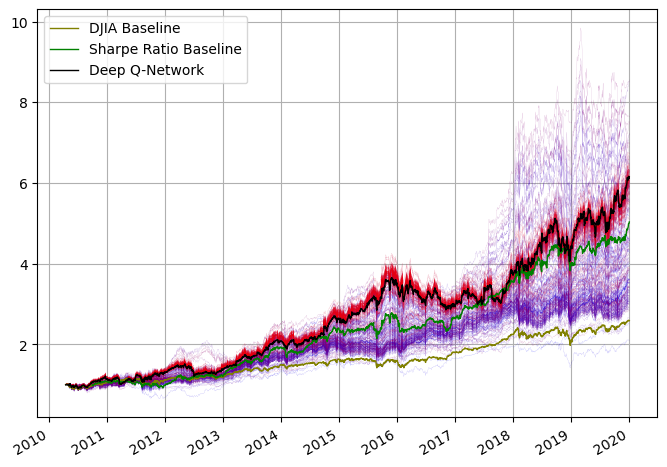

In [27]:
env = PortfolioEnv(train_df, RETURN_COLS, FEATURE_COLS, window_size=10, episode_length=-1, allocations_in_obs=True)
model = DQN.load(f'{models_dir}/{2_900_000}')
obs, done = env.reset(), False
while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, _reward, done, _info = env.step(action)
model_train_returns = env.get_portfolio_returns().copy()
del model

plt.figure(figsize=(8,6))
for model_number, returns in train_returns_dict.items():
    (1+returns).cumprod().plot(alpha=0.5, lw=0.1, color=linear_color_map(model_number/max(train_returns_dict.keys())))
(1+djia_returns.loc[djia_returns.index.intersection(model_train_returns.index)]).cumprod().plot(color='olive', lw=1, label='DJIA Baseline');
(1+max_sharpe_returns.loc[max_sharpe_returns.index.intersection(model_train_returns.index)]).cumprod().plot(color='green', lw=1, label='Sharpe Ratio Baseline');
(1+model_train_returns).cumprod().plot(color='black', lw=1, label='Deep Q-Network');
plt.legend();
plt.grid();

In [28]:
print('DJIA:', returns_to_stats(djia_returns.loc[djia_returns.index.intersection(model_train_returns.index)]))
print('Max Sharpe:', returns_to_stats(max_sharpe_returns.loc[max_sharpe_returns.index.intersection(model_train_returns.index)]))
print('Deep Q-Network:', returns_to_stats(model_train_returns))

DJIA: {'rate of return': 0.10296070153125214, 'risk': 0.14104934659841198, 'sharpe': 0.7299622721712866}
Max Sharpe: {'rate of return': 0.19096354674928695, 'risk': 0.16914826556166043, 'sharpe': 1.128971356077394}
Deep Q-Network: {'rate of return': 0.20570032735361088, 'risk': 0.21630473392153582, 'sharpe': 0.9509746903099603}


### Validation Data

In [29]:
val_returns_dict = get_returns_from_models(val_df, start_timestep=10_000, end_timestep=3_000_000, step=10_000)

  0%|          | 0/299 [00:00<?, ?it/s]

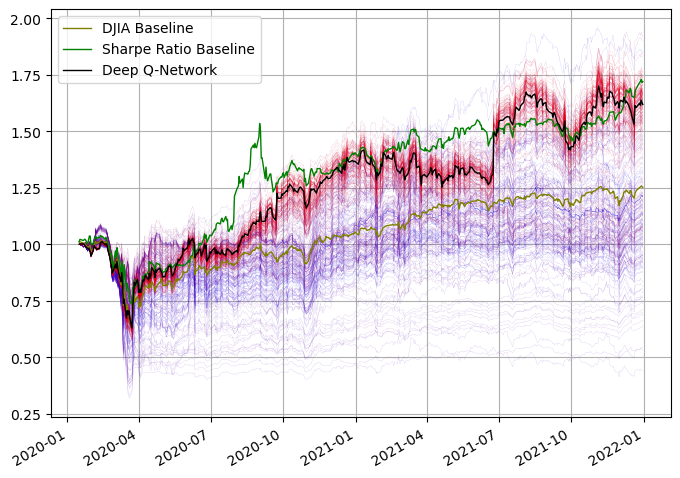

In [30]:
env = PortfolioEnv(val_df, RETURN_COLS, FEATURE_COLS, window_size=10, episode_length=-1, allocations_in_obs=True)
model = DQN.load(f'{models_dir}/{2_900_000}')
obs, done = env.reset(), False
while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, _reward, done, _info = env.step(action)
model_val_returns = env.get_portfolio_returns().copy()
del model

plt.figure(figsize=(8,6))
for model_number, returns in val_returns_dict.items():
    (1+returns).cumprod().plot(alpha=0.5, lw=0.1, color=linear_color_map(model_number/max(train_returns_dict.keys())))
(1+djia_returns.loc[djia_returns.index.intersection(returns.index)]).cumprod().plot(color='olive', lw=1, label='DJIA Baseline');
(1+max_sharpe_returns.loc[max_sharpe_returns.index.intersection(returns.index)]).cumprod().plot(color='green', lw=1, label='Sharpe Ratio Baseline');
(1+model_val_returns).cumprod().plot(color='black', lw=1, label='Deep Q-Network');
plt.legend();
plt.grid();

In [31]:
print('DJIA:', returns_to_stats(djia_returns.loc[djia_returns.index.intersection(model_val_returns.index)]))
print('Max Sharpe:', returns_to_stats(max_sharpe_returns.loc[max_sharpe_returns.index.intersection(model_val_returns.index)]))
print('Deep Q-Network:', returns_to_stats(model_val_returns))

DJIA: {'rate of return': 0.12109814074104142, 'risk': 0.27678284711303075, 'sharpe': 0.43752039551637445}
Max Sharpe: {'rate of return': 0.31776475119020686, 'risk': 0.31900094172608223, 'sharpe': 0.9961248059984197}
Deep Q-Network: {'rate of return': 0.27764394274626625, 'risk': 0.332562666083249, 'sharpe': 0.8348620307150316}


### Test Data

In [32]:
test_returns_dict = get_returns_from_models(test_df, start_timestep=10_000, end_timestep=3_000_000, step=10_000)

  0%|          | 0/299 [00:00<?, ?it/s]

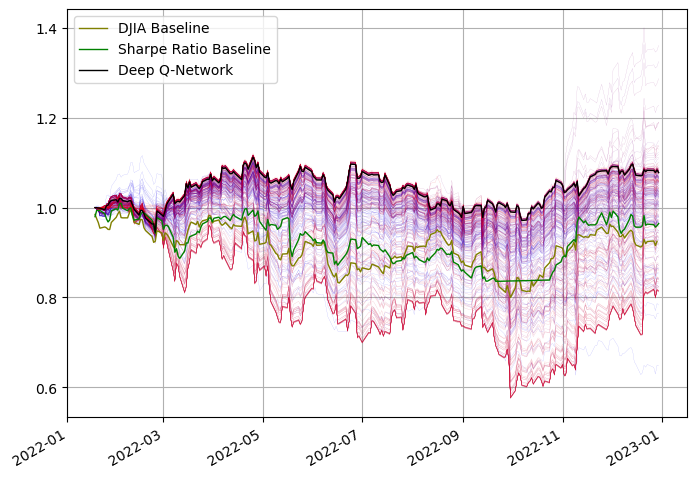

In [33]:
env = PortfolioEnv(test_df, RETURN_COLS, FEATURE_COLS, window_size=10, episode_length=-1, allocations_in_obs=True)
model = DQN.load(f'{models_dir}/{2_900_000}')
obs, done = env.reset(), False
while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, _reward, done, _info = env.step(action)
model_test_returns = env.get_portfolio_returns().copy()
del model

plt.figure(figsize=(8,6))
for model_number, returns in test_returns_dict.items():
    (1+returns).cumprod().plot(alpha=0.5, lw=0.1, color=linear_color_map(model_number/max(train_returns_dict.keys())))
(1+djia_returns.loc[djia_returns.index.intersection(returns.index)]).cumprod().plot(color='olive', lw=1, label='DJIA Baseline');
(1+max_sharpe_returns.loc[max_sharpe_returns.index.intersection(returns.index)]).cumprod().plot(color='green', lw=1, label='Sharpe Ratio Baseline');
(1+model_test_returns).cumprod().plot(color='black', lw=1, label='Deep Q-Network');
plt.legend();
plt.grid();

In [34]:
print('DJIA:', returns_to_stats(djia_returns.loc[djia_returns.index.intersection(model_test_returns.index)]))
print('Max Sharpe:', returns_to_stats(max_sharpe_returns.loc[max_sharpe_returns.index.intersection(model_test_returns.index)]))
print('Deep Q-Network:', returns_to_stats(model_test_returns))

DJIA: {'rate of return': -0.07852944933247241, 'risk': 0.2019180954469225, 'sharpe': -0.3889173437311624}
Max Sharpe: {'rate of return': -0.0370768025350362, 'risk': 0.19584903992536845, 'sharpe': -0.1893131697207448}
Deep Q-Network: {'rate of return': 0.08151203045465483, 'risk': 0.17190868831813075, 'sharpe': 0.47415887615761637}


### Conclusions
- RL is feasable
- The test data shows it even beating the Sharpe ratio (the RL algorithm can exit the market but the red line cannot)
- Shows that RL is definetely an alternative model for the Sharpe Ratio model

Future work:
- Verify it with different data/time/underlying securities
- Optimize hyperparameters
- Trading costs